Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

### Задачи
1. Загрузить [данные](https://disk.yandex.ru/d/c4t6B6OFDANVbg), проверить число наблюдений и столбцов, наличие пропусков. Убедьтся, что типы данных были прочитаны правильно. При необходимости – привсти переменные к нужным типам.  
2. Построить график по числу поездок по дате и времени.  
3. Преобразовать данные и посчитать число поездок по дням. Визуализировать результат.  
4. Использовать агрегированные данные по дням и посчитать скользящее среднее с окном 3.   
5. Посчитать разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. Найти стандартное отклонение.
6. Определить границы 99% доверительного интервала, добавить данную информацию в датафрейм.  
7. Изучить аномально высокие значения и найти день, когда число аренд было наибольшим. Найти причину данной аномалии.
8. Изучить аномально низкие значения, найти день с наименьшим числом аренд. Найти причину данной аномалии.

### Описание данных
`timestamp` – дата и время (точность до часа)  
`cnt` – количество аренд велосипедов за этот час  
`t1` – температура, в С  
`t2` – температура "ощущается как", в С   
`hum` – влажность (%)  
`wind_speed` – скорость ветра, км/ч  
`weather_code` – погодные условия:  
- 1 – ясно (SKC)  
- 2 – преимущественно ясно / встречаются отдельные облака (SCT)  
- 3 – облачно / значительные облака (BKN)  
- 4 – пасмурно (OVC)  
- 7 – небольшой дождь Rain/ light Rain shower/ Light rain   
- 10 – дождь с грозой  
- 26 – снегопад   
- 94 – ледяной туман (да, такое бывает!)  

`isholiday` – является ли день праздником (1 – праздник, 0 – нет)  
`isweekend` –  является ли день выходным (1 – выходной, 0 – нет)  
`season` – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from urllib.parse import urlencode

In [2]:
# скачиваем данные в папку со скриптом
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/c4t6B6OFDANVbg'                       # ссылка на данные

# получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('london.csv', 'wb') as f:
    f.write(download_response.content)

In [3]:
# считываем данные
london = pd.read_csv('london.csv')

In [4]:
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
# размер датафрэйма
london.shape

(17414, 10)

In [6]:
# типы данных
london.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [7]:
# переведём колонку со временем в формат времени
london['timestamp'] = pd.to_datetime(london['timestamp'])

In [8]:
# типы данных после преобразования
london.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [9]:
# пропущенные значения
london.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [10]:
# дублирующиеся значения
london.duplicated().sum()

0

In [11]:
# строки с дубликатами
london.loc[london.duplicated(keep=False)]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season


Здесь всё впорядке, значения колонок действительно совпадают, но даты разные

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

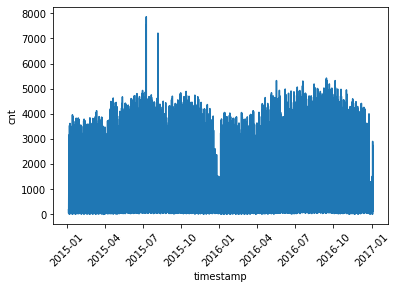

In [12]:
# график количества аренд по датам
sns.lineplot(data=london, x='timestamp', y='cnt')
sns.set(rc={"figure.figsize":(14, 16)})              # размер графика
plt.xticks(rotation=45)

Сложно что-то понять по такому графику. Попробуем преобразовать данные так, чтобы улучшить картину.

In [13]:
# перводим колонку со временем в индекс
london = london.sort_values('timestamp').set_index('timestamp')

In [14]:
london.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [15]:
# сагрегируем данные по дням (были по часам - суммируем значения)
cnt_plot = (
    london
        .resample(rule='D')
        .cnt
        .sum()
        .to_frame()
        .reset_index()
)

In [16]:
cnt_plot.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

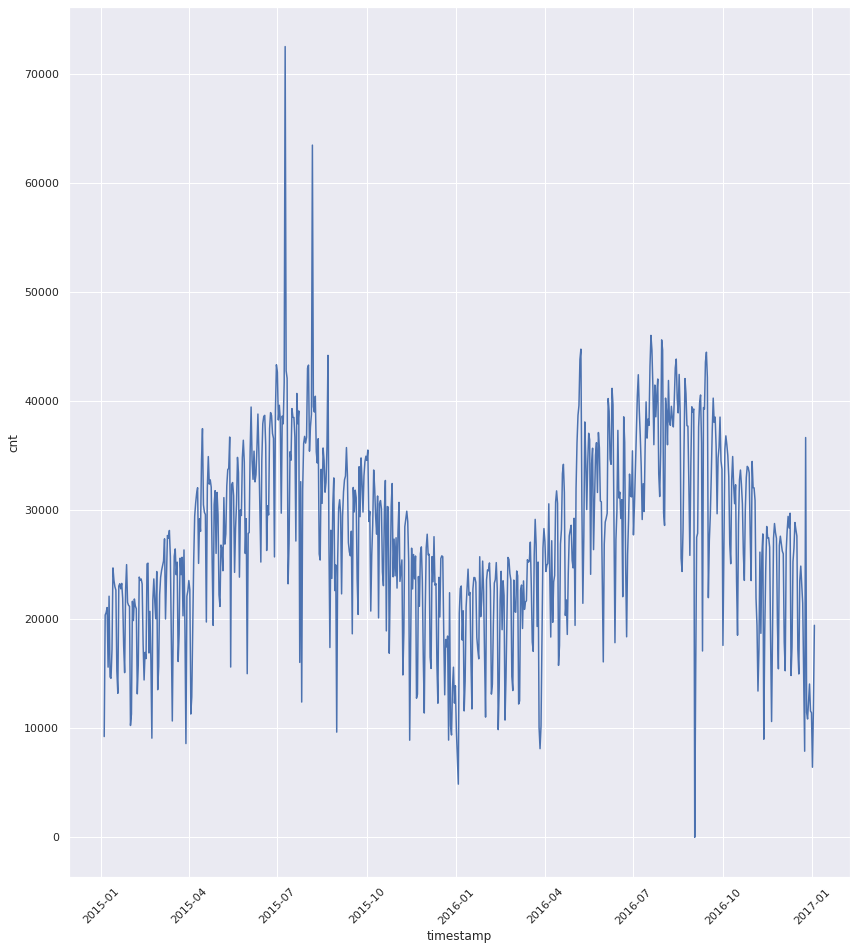

In [17]:
# снова построим график
sns.lineplot(data=cnt_plot, x='timestamp', y='cnt')
sns.set(rc={"figure.figsize":(14, 16)})              # размер графика
plt.xticks(rotation=45)

Встречаются как очень резкие скачки числа аренд, так и падения. Проверим, что же могло произойти в тот день.

In [18]:
# посчитаем скользящее среднее, чтобы сгладить ряд
cnt_plot['rolling_mean'] = cnt_plot.rolling(3).mean()

In [19]:
cnt_plot.head()

,timestamp,cnt,rolling_mean
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667


In [20]:
(
    cnt_plot
    .query('timestamp == "2015-07-09"')
)

,timestamp,cnt,rolling_mean
186,2015-07-09,72504,50705.0


In [21]:
# найдём разницу между наблюдаемыми и сглаженными значениями
cnt_plot['delta'] = cnt_plot.cnt - cnt_plot.rolling_mean
cnt_plot.head()

,timestamp,cnt,rolling_mean,delta
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333
3,2015-01-07,21064,20683.000000,381.000000
4,2015-01-08,15601,19092.666667,-3491.666667


In [22]:
# посчитаем стандартное отклонение
standard_deviation = np.std(cnt_plot.delta)

In [23]:
# определим границы 99% доверительного интервала
cnt_plot['upper_bound'] = cnt_plot.rolling_mean + (2.576 * standard_deviation)
cnt_plot['lower_bound'] = cnt_plot.rolling_mean - (2.576 * standard_deviation)

In [24]:
cnt_plot.head()

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479


In [25]:
# наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала
cnt_plot.query('cnt > upper_bound')

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


In [26]:
# максимальное значение cnt
cnt_plot.query('cnt > upper_bound').cnt.max()

72504

In [27]:
# день с максимальным количеством аренд (cnt)
cnt_plot[cnt_plot.cnt == cnt_plot.query('cnt > upper_bound').cnt.max()]

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
186,2015-07-09,72504,50705.0,21799.0,62447.919188,38962.080812


In [28]:
# дни, когда число аренд оказалось ниже ожидаемого
cnt_plot.query('cnt < lower_bound')

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812


In [29]:
# день с минимальным числом аренд
cnt_plot[cnt_plot.cnt == cnt_plot.query('cnt < lower_bound').cnt.min()]

,timestamp,cnt,rolling_mean,delta,upper_bound,lower_bound
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146


Причина аномалии - ошибка данных